In [104]:
a = np.array([1, 2, 3])
b = np.array([3, 2, 1])

c = []
c.append(a)
print(c)
c.append(b)
print(c)

c[0] == c[1]

[array([1, 2, 3])]
[array([1, 2, 3]), array([3, 2, 1])]


array([False,  True, False])

In [4]:
import numpy as np
from numba import vectorize

@vectorize(['float32(float32, float32)'], target='cuda')
def Add(a, b):
  return a + b

# Initialize arrays
N = int(1e8)
A = np.ones(N, dtype=np.float32)
B = np.ones(A.shape, dtype=A.dtype)
C = np.empty_like(A, dtype=A.dtype)

# Add arrays on GPU
C = Add(A, B)

C:\Users\wangk\anaconda3\lib\site-packages\numba\cuda\decorators.py:110: NumbaDeprecationWarning: Eager compilation of device functions is deprecated (this occurs when a signature is provided)
  warn(NumbaDeprecationWarning(msg))


# Numba parallelization test!

In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\wangk\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['vectorize']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp
from matplotlib import animation

### Successive Over Relaxation

In [7]:
from numba import jit, njit, vectorize

def SOR_solver(i, j, n_i, c_k, c_k_1, w=1.8):

    # boundary conditions
    if i == 0:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
    elif i == n_i-1:
        c_new = w/4 * (c_k[0, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
        
    else:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]

    return c_new

## Implement

### Successive Over Relaxation (SOR)

#### Object detector

In [ ]:
def object_detector(i, j, num=0, length=0, lower_bound=0, upper_bound=1):
    num = num 
    l = length
    passcheck = 0

    a1 = (1-l)/2
    b1 = (1+l)/2

    a2 = (1-2*l)/3
    a3 = (2-l)/3
    b2 = (1+l)/3
    b3 = (2+2*l)/3

    if num == 1:
        if ((j > a1) and (j < b1)) and ((i > a1) and (i < b1)):
            passcheck = 1

    if num == 2:
        if ((j > a1) and (j < b1)) and \
            (((i > a2) and (i < b2)) or ((i > a3) and (i < b3))):
            passcheck = 1

    if num == 4:
        if (((j > a2) and (j < b2)) or ((j > a3) and (j < b3))) and \
            (((i > a2) and (i < b2)) or ((i > a3) and (i < b3))):
            passcheck = 1
    
    return passcheck


In [ ]:
def implement_sor(max_ite=5000, w=1.8, e=1e-5, N=50, num=0, length=0):
    ##########################################################
    # Initialize valuse
    max_ite = max_ite
    e = e
    delta_x = 1 / N
    # check the number of sinks
    num = num
    if num == 3 or num > 4:
        print('num can only take value 1, 2 or 4!')
        return None
    ###########################################################
    # Create tracker matrix
    c_store_s = np.zeros((max_ite+1, N, N))
    c_store_s[:, :, -1].fill(1)

    # Store the convergence measure delta
    delta_s = np.zeros(max_ite+1)

    # create matrix to store function value at the last step
    c_keep_s = np.zeros((N, N))
    c_keep_s[:, -1].fill(1)

    # Create matrix to store function value at the current step
    c_s = np.zeros((N, N))
    c_s[:, -1].fill(1)
    ##################################################################################
    # apply the sor method (pity that I don't know how to enable parellel computing :( )
    for k in range(max_ite):
        for j in range(N-2):
            j += 1
            for i in range(N):
                ####################################################################          
                # Check if the point (i,j) lies within the sink!
                passcheck = object_detector(i=i*delta_x, j=j*delta_x, num=num, length=length)
                if passcheck == 0:
                    c_s[i, j] = SOR_solver(i, j, n_i=N, c_k=c_keep_s, c_k_1=c_s, w=w)
                else:
                    c_s[i, j] = 0
                ####################################################################
        
        # Update the tracker
        c_store_s[k+1, :, :] = c_s
        
        # apply the threshold
        diff_s = c_s - c_keep_s
        delta_s[k] = abs(max(diff_s.max(), diff_s.min(), key=abs))
        
        if delta_s[k] < e:
            break

        # update the store matrix
        c_keep_s = np.copy(c_s)
    #####################################################################################

    return c_store_s, delta_s, k


In [ ]:
if __name__ == '__main__':
    c_store_s, delta_s, k_s = implement_sor(w=1.8)
print(k_s)

424


## Numba

In [8]:
from numba import jit, njit, vectorize, prange
import time

@vectorize
def sor_rb_solver(c_i_j, c_i_0, c_i_1, c_j_0, c_j_1, w=1.8):

    c_new = w/4 * (c_i_0 + c_i_1 + c_j_0 + c_j_1) + (1-w) * c_i_j

    return c_new

In [9]:
# construct the red_black ordering grid
# Note that red block: odd & odd and even & even; black block: even & odd and odd & even

def red_black_grid(N):
    x = np.linspace(0, N-1, N, dtype=int)
    # Note that the index of y starts from j=1
    y = np.linspace(1, N-2, N-2, dtype=int)

    red_block = set()
    black_block = set()
    for p in range(len(x)):
        i = x[p]
        for j in y:
            if ((i+j) % 2 == 1):
                red_block.update({(i, j)})
            else:
                black_block.update({(i, j)}) 

    red = list(red_block)
    black = list(black_block)

    # get the indices for red and black blocks
    red_indices = np.array(([i[0] for i in red], [i[1] for i in red]))
    black_indices = np.array(([i[0] for i in black], [i[1] for i in black]))

    return red_indices, black_indices

In [10]:
def lattice_value_finder(c_n, b_ind, N):

    b_i0, b_i1, b_j0, b_j1 = np.array((b_ind[0]-1, b_ind[1])), np.array((b_ind[0]+1, b_ind[1])), \
        np.array((b_ind[0], b_ind[1]-1)), np.array((b_ind[0], b_ind[1]+1))
    
    '''
    Watch out here, might be wrong!
    '''
    # Adjust the block index for boundary conditions (periodic x)
    b_i0[b_i0 < 0] = N - 1
    b_i1[b_i1 >= N] = 0

    b_ind, b_i0, b_i1, b_j0, b_j1 = tuple(b_ind), tuple(b_i0), tuple(b_i1), tuple(b_j0), tuple(b_j1), 

    c, c_i0, c_i1, c_j0, c_j1 = c_n[b_ind], c_n[b_i0], c_n[b_i1], c_n[b_j0], c_n[b_j1]

    return c, c_i0, c_i1, c_j0, c_j1

In [11]:
def get_c_next(c_n, red_indices, black_indices, N=100, w=1.8):

    c_n = np.copy(c_n)

    ######################################################################################################
    start_red_value_finder = time.time()

    # get the c value for red blocks
    c_red = lattice_value_finder(c_n=c_n, b_ind=red_indices, N=N)
    c_red_ij, c_red_i0, c_red_i1, c_red_j0, c_redj1 = c_red[0], c_red[1], c_red[2], c_red[3], c_red[4]

    end_red_value_finder = time.time()
    value_finder_time = end_red_value_finder - start_red_value_finder
    ######################################################################################################
    ###################################################################################
    start_calculation = time.time()

    # update all the c_n+1 value for red blocks
    c_n_red = sor_rb_solver(c_red_ij, c_red_i0, c_red_i1, c_red_j0, c_redj1, 1.93)
    c_n[tuple(red_indices)] = c_n_red

    end_calculation = time.time()
    calculation_time = end_calculation - start_calculation
    ####################################################################################
    ########################################################################################################################
    start_b_value_finder = time.time()
    # get the c value for black blocks
    c_black = lattice_value_finder(c_n=c_n, b_ind=black_indices, N=N)

    c_black_ij, c_black_i0, c_black_i1, c_black_j0, c_black_j1 = c_black[0], c_black[1], c_black[2], c_black[3], c_black[4]
    end_b_value_finder = time.time()
    value_finder_time_b = end_b_value_finder - start_b_value_finder
    ########################################################################################################################
    ##########################################################################################
    start_black_calculation = time.time()

    # update all the c_n+1 value for black blocks
    c_n_black = sor_rb_solver(c_black_ij, c_black_i0, c_black_i1, c_black_j0, c_black_j1, w)
    c_n[tuple(black_indices)] = c_n_black
    
    end_black_calculation = time.time()
    calculation_time_black = end_black_calculation - start_black_calculation
    ###########################################################################################
    
    # return the c_next matrix
    return c_n, value_finder_time, calculation_time, calculation_time_black, value_finder_time_b

In [92]:
%%time
if __name__ == '__main__':
    # Define parameters
    N = 100
    w = 1.8
    e = 1e-5

    # start from rest
    c_s = np.zeros((N, N))
    c_s[:, -1].fill(1)

    time_grid_generate = 0
    value_finder_time = 0
    v_finder_b = 0
    calculation_time = 0
    calcu_t_b = 0
    check_time = 0

    # Generate red_black_grid
    start_grid = time.time()
    red, black = red_black_grid(N)
    end_grid = time.time()
    
    time_grid_generate += (end_grid - start_grid)


    for k in range(3000):
        
        c_s_next, value_finder_t, calculation_t, calculation_t_b, value_b_finder = \
            get_c_next(c_n=c_s, red_indices=red, black_indices=black, N=N, w=w)

        value_finder_time += value_finder_time
        calculation_time += calculation_t
        calcu_t_b += calculation_t_b
        v_finder_b += value_b_finder

        check_t_s = time.time()

        # apply the threshold
        diff_s = c_s_next - c_s
        delta_s = abs(max(diff_s.max(), diff_s.min(), key=abs))
        
        if delta_s < e:
            break

        # update the store matrix
        c_s = np.copy(c_s_next)
        
        check_t_e = time.time()
        check_time += check_t_e - check_t_s
        
        if k % 200 == 0:
            print(k, end=',')

0,200,400,600,800,Wall time: 488 ms


In [93]:
print( time_grid_generate, value_finder_time, calculation_time, calcu_t_b, check_time, v_finder_b)

0.009002447128295898 0 0.049005985260009766 0.0490117073059082 0.02100348472595215 0.17804503440856934


In [37]:
a = np.array(([1, 2, 3], [1, 5, 3]))
b = ([0, 1], [0, 1])
c = a[b]
print(c)

[1 5]


In [72]:
%%time
if __name__ == '__main__':
    # Define parameters
    N = 100
    w = 1.8
    e = 1e-5

    # start from rest
    c_s = np.zeros((N, N))
    c_s[:, -1].fill(1)

    time_grid_generate = 0
    value_finder_time = 0
    calculation_time = 0

    # Generate red_black_grid
    start_grid = time.time()
    red, black = red_black_grid(N)
    end_grid = time.time()
    
    time_grid_generate += (end_grid - start_grid)


    for k in range(2000):
        
        c_s_next, value_finder_t, calculation_t = get_c_next(c_n=c_s, red_indices=red, black_indices=black, N=N, w=w)

        value_finder_time += value_finder_time
        calculation_time += calculation_t

        # apply the threshold
        diff_s = c_s_next - c_s
        delta_s = abs(max(diff_s.max(), diff_s.min(), key=abs))
        
        if delta_s < e:
            break

        # update the store matrix
        c_s = np.copy(c_s_next)
        
        if k % 200 == 0:
            print(k, end=',')

0,200,400,600,800,Wall time: 488 ms


In [17]:
print( time_grid_generate, value_finder_time, calculation_time)

0.015003204345703125 0 0.18203353881835938


Locator attempting to generate 1001 ticks ([0.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).


Text(0.5, 0, 'x')

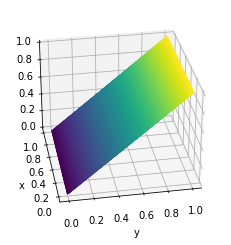

In [476]:
ax3d = plt.axes(projection='3d')

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

ax3d.contour3D(X, Y, c_s_next, 999)
ax3d.view_init(30, -100)
ax3d.set_xlabel('y')
ax3d.set_ylabel('x')

## Try parallel using numba

In [1]:
from numba import  vectorize, cuda, types
import time

@cuda.jit
def sor_rb_solver_gpu(c_i_j, c_i_0, c_i_1, c_j_0, c_j_1, w, c_out):

    for i in range(len(c_i_0)):
        c_out[i] = w/4 * (c_i_0[i] + c_i_1[i] + c_j_0[i] + c_j_1[i]) + (1-w) * c_i_j[i]

In [14]:
def get_c_next_gpu(c_n, red_indices, black_indices, b_size, t_size, N=100, w=1.8):

    array_len = int(N * (N-2) / 2)

    c_n = np.copy(c_n)

    ##################################################################################################################
    start_red_value_finder = time.time()
    # get the c value for red blocks
    c_red = lattice_value_finder(c_n=c_n, b_ind=red_indices, N=N)
    c_red_ij, c_red_i0, c_red_i1, c_red_j0, c_red_j1 = c_red[0], c_red[1], c_red[2], c_red[3], c_red[4]

    c_red_ij = cuda.to_device(c_red_ij)
    c_red_i0 = cuda.to_device(c_red_i0)
    c_red_i1 = cuda.to_device(c_red_i1)
    c_red_j0 = cuda.to_device(c_red_j0)
    c_red_j1 = cuda.to_device(c_red_j1)


    # red_out = cuda.device_array(shape=(array_len), dtype=np.float32)

    c_n_red = np.zeros(array_len, dtype=np.float32)

    end_red_value_finder = time.time()
    value_finder_time = end_red_value_finder - start_red_value_finder
    ##################################################################################################################

    start_calculation = time.time()

    # update all the c_n+1 value for red blocks
    sor_rb_solver_gpu[b_size, t_size](c_red_ij, c_red_i0, c_red_i1, c_red_j0, c_red_j1, w, c_n_red)

    # h_red = red_out.copy_to_host()

    c_n[tuple(red_indices)] = c_n_red

    end_calculation = time.time()

    calculation_time = end_calculation - start_calculation
    ####################################################################################################################

    # get the c value for black blocks
    c_black = lattice_value_finder(c_n=c_n, b_ind=black_indices, N=N)
    c_black_ij, c_black_i0, c_black_i1, c_black_j0, c_black_j1 = c_black[0], c_black[1], c_black[2], c_black[3], c_black[4]


    c_black_ij = cuda.to_device(c_black_ij)
    c_black_i0 = cuda.to_device(c_black_i0)
    c_black_i1 = cuda.to_device(c_black_i1)
    c_black_j0 = cuda.to_device(c_black_j0)
    c_black_j1 = cuda.to_device(c_black_j1)    


    # black_out = cuda.device_array(shape=(array_len), dtype=np.float32)

    c_n_black = np.zeros(array_len, dtype=np.float32)

    start_time_b = time.time()
    
    # update all the c_n+1 value for black blocks
    sor_rb_solver_gpu[b_size, t_size](c_black_ij, c_black_i0, c_black_i1, c_black_j0, c_black_j1, w, c_n_black)

    # h_black = black_out.copy_to_host()
        
    c_n[tuple(black_indices)] = c_n_black

    calculation_time_b = time.time() - start_time_b
    
    # return the c_next matrix
    return c_n, value_finder_time, calculation_time, calculation_time_b

In [15]:
%%time
if __name__ == '__main__':
    # Define parameters
    N = 100
    w = np.float32(1.8)
    e = 1e-5

    # start from rest
    c_s = np.zeros((N, N), dtype=np.float32)
    c_s[:, -1].fill(1)

    time_grid_generate = 0
    value_finder_time = 0
    calculation_time = 0

    # Generate red_black_grid
    start_grid = time.time()
    red, black = red_black_grid(N)
    end_grid = time.time()
    
    time_grid_generate += (end_grid - start_grid)

    # Launch the cuda threads and blocks
    array_size = N * (N-2) / 2
    thread_size = 32
    block_size = (N*(N-2)) // thread_size


    for k in range(2000):
        
        c_s_next, value_finder_t, calculation_t, calculation_b = get_c_next_gpu(\
            c_n=c_s, red_indices=red, black_indices=black, \
                b_size=block_size, t_size=thread_size ,N=N, w=w)

        value_finder_time += value_finder_time
        calculation_time += calculation_t + calculation_b

        # apply the threshold
        diff_s = c_s_next - c_s
        delta_s = abs(max(diff_s.max(), diff_s.min(), key=abs))
        
        if delta_s < e:
            break

        # update the store matrix
        c_s = np.copy(c_s_next)
        
        if k % 200 == 0:
            print(k, end=',')

C:\Users\wangk\anaconda3\lib\site-packages\numba\cuda\cudadrv\devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


0,200,400,600,800,1000,1200,Wall time: 11.1 s


In [17]:
print( time_grid_generate, value_finder_time, calculation_time)

0.008000850677490234 0 7.971524000167847


In [185]:
a = np.ones((2, 10000))
print(a)

def v_stack(a):
    return np.array((a[0]-1, a[1]))

%time b = v_stack(a)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Wall time: 999 µs


In [201]:
arr = np.array(((2,3),(2,-2)))
print(arr)
tuple(map(tuple, arr))

[[ 2  3]
 [ 2 -2]]


((2, 3), (2, -2))

In [205]:
a = np.array([1, 2, 3, 4, 5, 6])

b = a[:-2]
b

array([1, 2, 3, 4])

In [208]:
u = np.ones((10+2, 10+2)) / 2
u = u * u 
1-u

array([[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
        0.75],
       [0.75, 0.75, 0